# Plot Weather Station Data from GHCN-Hourly
## Written By Jared Rennie (@jjrennie)

Taps into the NCEI Website to get hourly station data for a particular year and then plot a days worth of data. Some bonus plotting fun of Dew Point data will also be had!

The dataset we will be using is from the Global Historical Climatology Network's (GHCN's) hourly dataset, which includes multiple sources of US and international data, including airport data from the ASOS network. If you would like to learn more about this dataset, check out the information below. 

- GHCNh Info: https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly
- GHCNh Documentation: https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh_DOCUMENTATION.pdf

This notebook is designed so you do not have to download any data locally, and with just a few lines of code, you can download data and plots at your fingertips. Let's get into it!

### What You Need

First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- pandas (to slice annd dice the data)
- matplotlib (to plot the data)
- timezonefinder and pytz (to deal with timezone conversions)
    
The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import Packages
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import matplotlib.dates as mdates
from timezonefinder import TimezoneFinder
import pytz

print("SUCCESS!")

SUCCESS!


### If you made it this far, great!

### Insert Arguments
Since a stations entire period of record is very large, the database not only splits up data by year, but also uses the parquet file format. No need to worry though, we can read this data using pandas, without downloading any data locally!

As such, the codebase requires smoe inputs. First is station ID, which can either be 11 digits long (GHCN ID) or 4 digits long (ICAO id), and you can find the list of stations <a href='https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv' target='blank'>here</a>.
- example: Asheville Airport is USW00003812 OR KAVL

If you're not sure, you can refer to the documentation above. We will also need a date (YYYY-MM-DD) and then we want to give you the credit for the work as the author.

 **Change the arguments below to your liking**

In [2]:
# Insert Arguments Here
inStn = 'KBOS' # GHCN ID: USW00014739 | ICAO ID: KBOS
inDate='2024-06-20' # YYYY-MM-DD
author ='Not Jared Rennie (@jjrennie)' # Give yourself credit

### Get Station Metadata
The metadata information, like station's latitude and longitude, isn't fully in the data files, so let's get Metadata from CSV hosted on NCEI site

In [3]:
ghcnh_meta_url='https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv'
# Pull Data into Pandas DataFrame
try:
  ghcnhMeta = pd.read_csv(ghcnh_meta_url)
except Exception as e:
  print('SOMETHING WENT WRONG: ',e)
print('SUCCESS')
ghcnhMeta

SUCCESS


,GHCN_ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN,(US)HCN_(US)CRN,WMO_ID,ICAO
0,AAI0000TNCA,12.5014,-70.0152,18.3,NaN,REINA BEATRIX INTL,NaN,NaN,NaN,NaN
1,ACL000BARA9,17.5910,-61.8210,5.0,TX,BARBUDA,NaN,NaN,NaN,NaN
2,ACM00078861,17.1167,-61.7833,10.0,NaN,COOLIDGE FIELD ANTIGUA (AUX.,NaN,NaN,NaN,NaN
3,ACU55-00189,18.6000,-63.4700,10.0,NaN,SOMBRERO,NaN,NaN,NaN,NaN
4,ACU55-00190,18.6000,-63.4700,12.0,NaN,SOMBRERO,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
34176,ZIM00067967,-21.3833,28.9833,770.0,NaN,TULI,NaN,NaN,NaN,NaN
34177,ZIM00067974,-19.8333,30.7833,-999.9,NaN,MAKOHOLI,NaN,NaN,NaN,NaN
34178,ZIM00067976,-20.5500,31.0833,700.0,NaN,RUPIKE,NaN,NaN,NaN,NaN
34179,ZIM00067979,-20.3333,31.4667,770.0,NaN,ZAKA,NaN,NaN,NaN,NaN


Now get metadata for station requested. In theory it checks to see if it's the 11 digit GHCN ID or the 4 digit ICAO ID.

In [4]:
if len(inStn) == 11: 
    stnMeta=ghcnhMeta[ghcnhMeta['GHCN_ID'] == inStn]
elif len(inStn) == 4:
    stnMeta=ghcnhMeta[ghcnhMeta['ICAO'] == inStn]
else:
    print('STN MUST BE GHCN (ie USW00003812) or ICAO (KAVL)')
stnMeta

,GHCN_ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN,(US)HCN_(US)CRN,WMO_ID,ICAO
31939,USW00014739,42.3606,-71.0097,3.4,MA,BOSTON,NaN,NaN,72509,KBOS


Let's extract some specific metadata to help us with plotting later.

In [5]:
# Parse out some metadata
stnGHCN=stnMeta['GHCN_ID'].values[0]
stnICAO=stnMeta['ICAO'].values[0]
stnLat=stnMeta['LATITUDE'].values[0]
stnLon=stnMeta['LONGITUDE'].values[0]
stnElev=stnMeta['ELEVATION'].values[0]
stnState=stnMeta['STATE'].values[0]
stnName=stnMeta['NAME'].values[0].title()
print("SUCCESS!")

SUCCESS!


### Get Data
The rest of the code should work without making any changes to it, but if you're interested, keep on reading to see how the sausage is made.

This next block of code will attempt to access the data we want from the NCEI website

In [6]:
inYear=inDate[0:4]

# DEFINE URL (parquet)
ghcnh_url = 'https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/access/by-year/'+str(inYear)+'/parquet/GHCNh_'+str(stnGHCN)+'_'+str(inYear)+'.parquet'

# Pull Data into Pandas DataFrame
try:
  ghcnhPandas = pd.read_parquet(ghcnh_url)
except Exception as e:
  print('SOMETHING WENT WRONG: ',e)
print('SUCCESS')

SUCCESS


If it says "SUCCESS!" then congrats you got the data!

### Let's check the data!
How does it look? Let's pull out a subset. For plotting, we are only grabbing temperature, dew point, precipitation and sky cover. Also the data is in UTC format, so we will use the timezone packages to get the local time

In [7]:
# Get a subset of Data based on User inputs
subsetCols=['DATE','temperature','dew_point_temperature','precipitation','sky_cover_1']
subsetPandas = ghcnhPandas[subsetCols].copy()

# Create Date in UTC and Local 
subsetPandas['DATE_UTC'] = pd.to_datetime(subsetPandas['DATE'], utc=True)

# Use stnLat and stnLon to find the timezone
tf = TimezoneFinder()
zone_result = tf.timezone_at(lat=stnLat, lng=stnLon)

if zone_result:
    local_tz = pytz.timezone(zone_result)
    # Convert UTC to local time
    subsetPandas['DATE_LOCAL'] = subsetPandas['DATE_UTC'].dt.tz_convert(local_tz)
else:
    print("⚠️ Timezone could not be determined for the provided coordinates.")
    subsetPandas['DATE_LOCAL'] = None
subsetPandas.drop(columns=['DATE','DATE_UTC'], inplace=True)
subsetPandas

,temperature,dew_point_temperature,precipitation,sky_cover_1,DATE_LOCAL
0,1.7,-5.0,NaN,None,2023-12-31 19:00:00-05:00
1,1.1,-5.0,0.0,OVC:08,2023-12-31 19:54:00-05:00
2,0.6,-5.6,0.0,OVC:08,2023-12-31 20:54:00-05:00
3,0.6,-5.0,0.0,OVC:08,2023-12-31 21:54:00-05:00
4,0.6,-5.0,NaN,None,2023-12-31 22:00:00-05:00
...,...,...,...,...,...
13664,6.7,1.1,0.0,SCT:04,2024-12-31 15:54:00-05:00
13665,6.7,1.1,NaN,None,2024-12-31 16:00:00-05:00
13666,5.6,2.2,NaN,None,2024-12-31 16:54:00-05:00
13667,5.0,2.2,NaN,None,2024-12-31 17:54:00-05:00


Now for the fun part!

### Plot Data For A Day
Let's get data for a day and plot it. This code picks of a specific day, converts data to imperial units, then gets the max and min temperature values for the day

In [8]:
filtered_df = subsetPandas[pd.to_datetime(subsetPandas['DATE_LOCAL'], errors='coerce').dt.date == pd.to_datetime(inDate).date()].reset_index()
filtered_df['temperature']=(filtered_df['temperature']* 1.8) + 32.
filtered_df['dew_point_temperature']=(filtered_df['dew_point_temperature']* 1.8) + 32.
filtered_df['precipitation']=(filtered_df['precipitation']* 0.0393701)

temp_max= "%.1f°F" % (np.max(filtered_df['temperature']))
temp_min= "%.1f°F" % (np.min(filtered_df['temperature']))
dewp_max= "%.1f°F" % (np.max(filtered_df['dew_point_temperature']))
dewp_min= "%.1f°F" % (np.min(filtered_df['dew_point_temperature']))
filtered_df

,index,temperature,dew_point_temperature,precipitation,sky_cover_1,DATE_LOCAL
0,6528,78.08,66.02,0.000000,FEW:02,2024-06-20 00:54:00-04:00
1,6529,77.00,64.94,0.000000,FEW:02,2024-06-20 01:54:00-04:00
2,6530,77.00,64.94,NaN,None,2024-06-20 02:00:00-04:00
3,6531,75.92,60.98,0.000000,BKN:07,2024-06-20 02:54:00-04:00
4,6532,75.02,57.92,0.000000,FEW:02,2024-06-20 03:54:00-04:00
5,6533,73.94,57.92,0.000000,FEW:02,2024-06-20 04:54:00-04:00
6,6534,73.94,57.92,NaN,None,2024-06-20 05:00:00-04:00
7,6535,73.94,59.00,0.000000,FEW:02,2024-06-20 05:54:00-04:00
8,6536,75.92,60.98,0.000000,FEW:02,2024-06-20 06:54:00-04:00
9,6537,78.98,64.94,0.000000,SCT:04,2024-06-20 07:54:00-04:00


This block tries to get the color info for plotting precipitation and cloud cover

In [9]:
####################
# Check Precip Info
filtered_df_rain=filtered_df[filtered_df['precipitation'].notna() & (filtered_df['precipitation']  > 0)].copy()

# Define bins and labels
bins = [0.009, 0.05, 0.10, 0.25, float('inf')]
labels = ['0.01–0.05', '0.05–0.10', '0.10–0.25', '>0.25']
color_map = {
    '0.01–0.05': '#edf8e9',
    '0.05–0.10': '#bae4b3',
    '0.10–0.25': '#74c476',
    '>0.25': '#238b45'
}

# Bin the values and map to colors
filtered_df_rain['precip_bin'] = pd.cut(filtered_df_rain['precipitation'], bins=bins, labels=labels)
filtered_df_rain['precip_color'] = filtered_df_rain['precip_bin'].map(color_map)

filtered_df_rain=filtered_df_rain.dropna()

####################
# Check Cloud Info
filtered_df_cloud=filtered_df[filtered_df['sky_cover_1'].notna() & (filtered_df['sky_cover_1'] != 'None')].copy()

# Define the color mapping
color_map = {
    'OVC': '#252525',
    'BKN': '#636363',
    'SCT': '#969696',
    'FEW': '#cccccc',
    'CLR': '#f7f7f7'
}

# Extract the prefix and map to color
filtered_df_cloud['color'] = filtered_df_cloud['sky_cover_1'].str[:3].map(color_map)
filtered_df_cloud=filtered_df_cloud.dropna()
print("SUCCESS")

SUCCESS


Now we plot!

PLOTTING


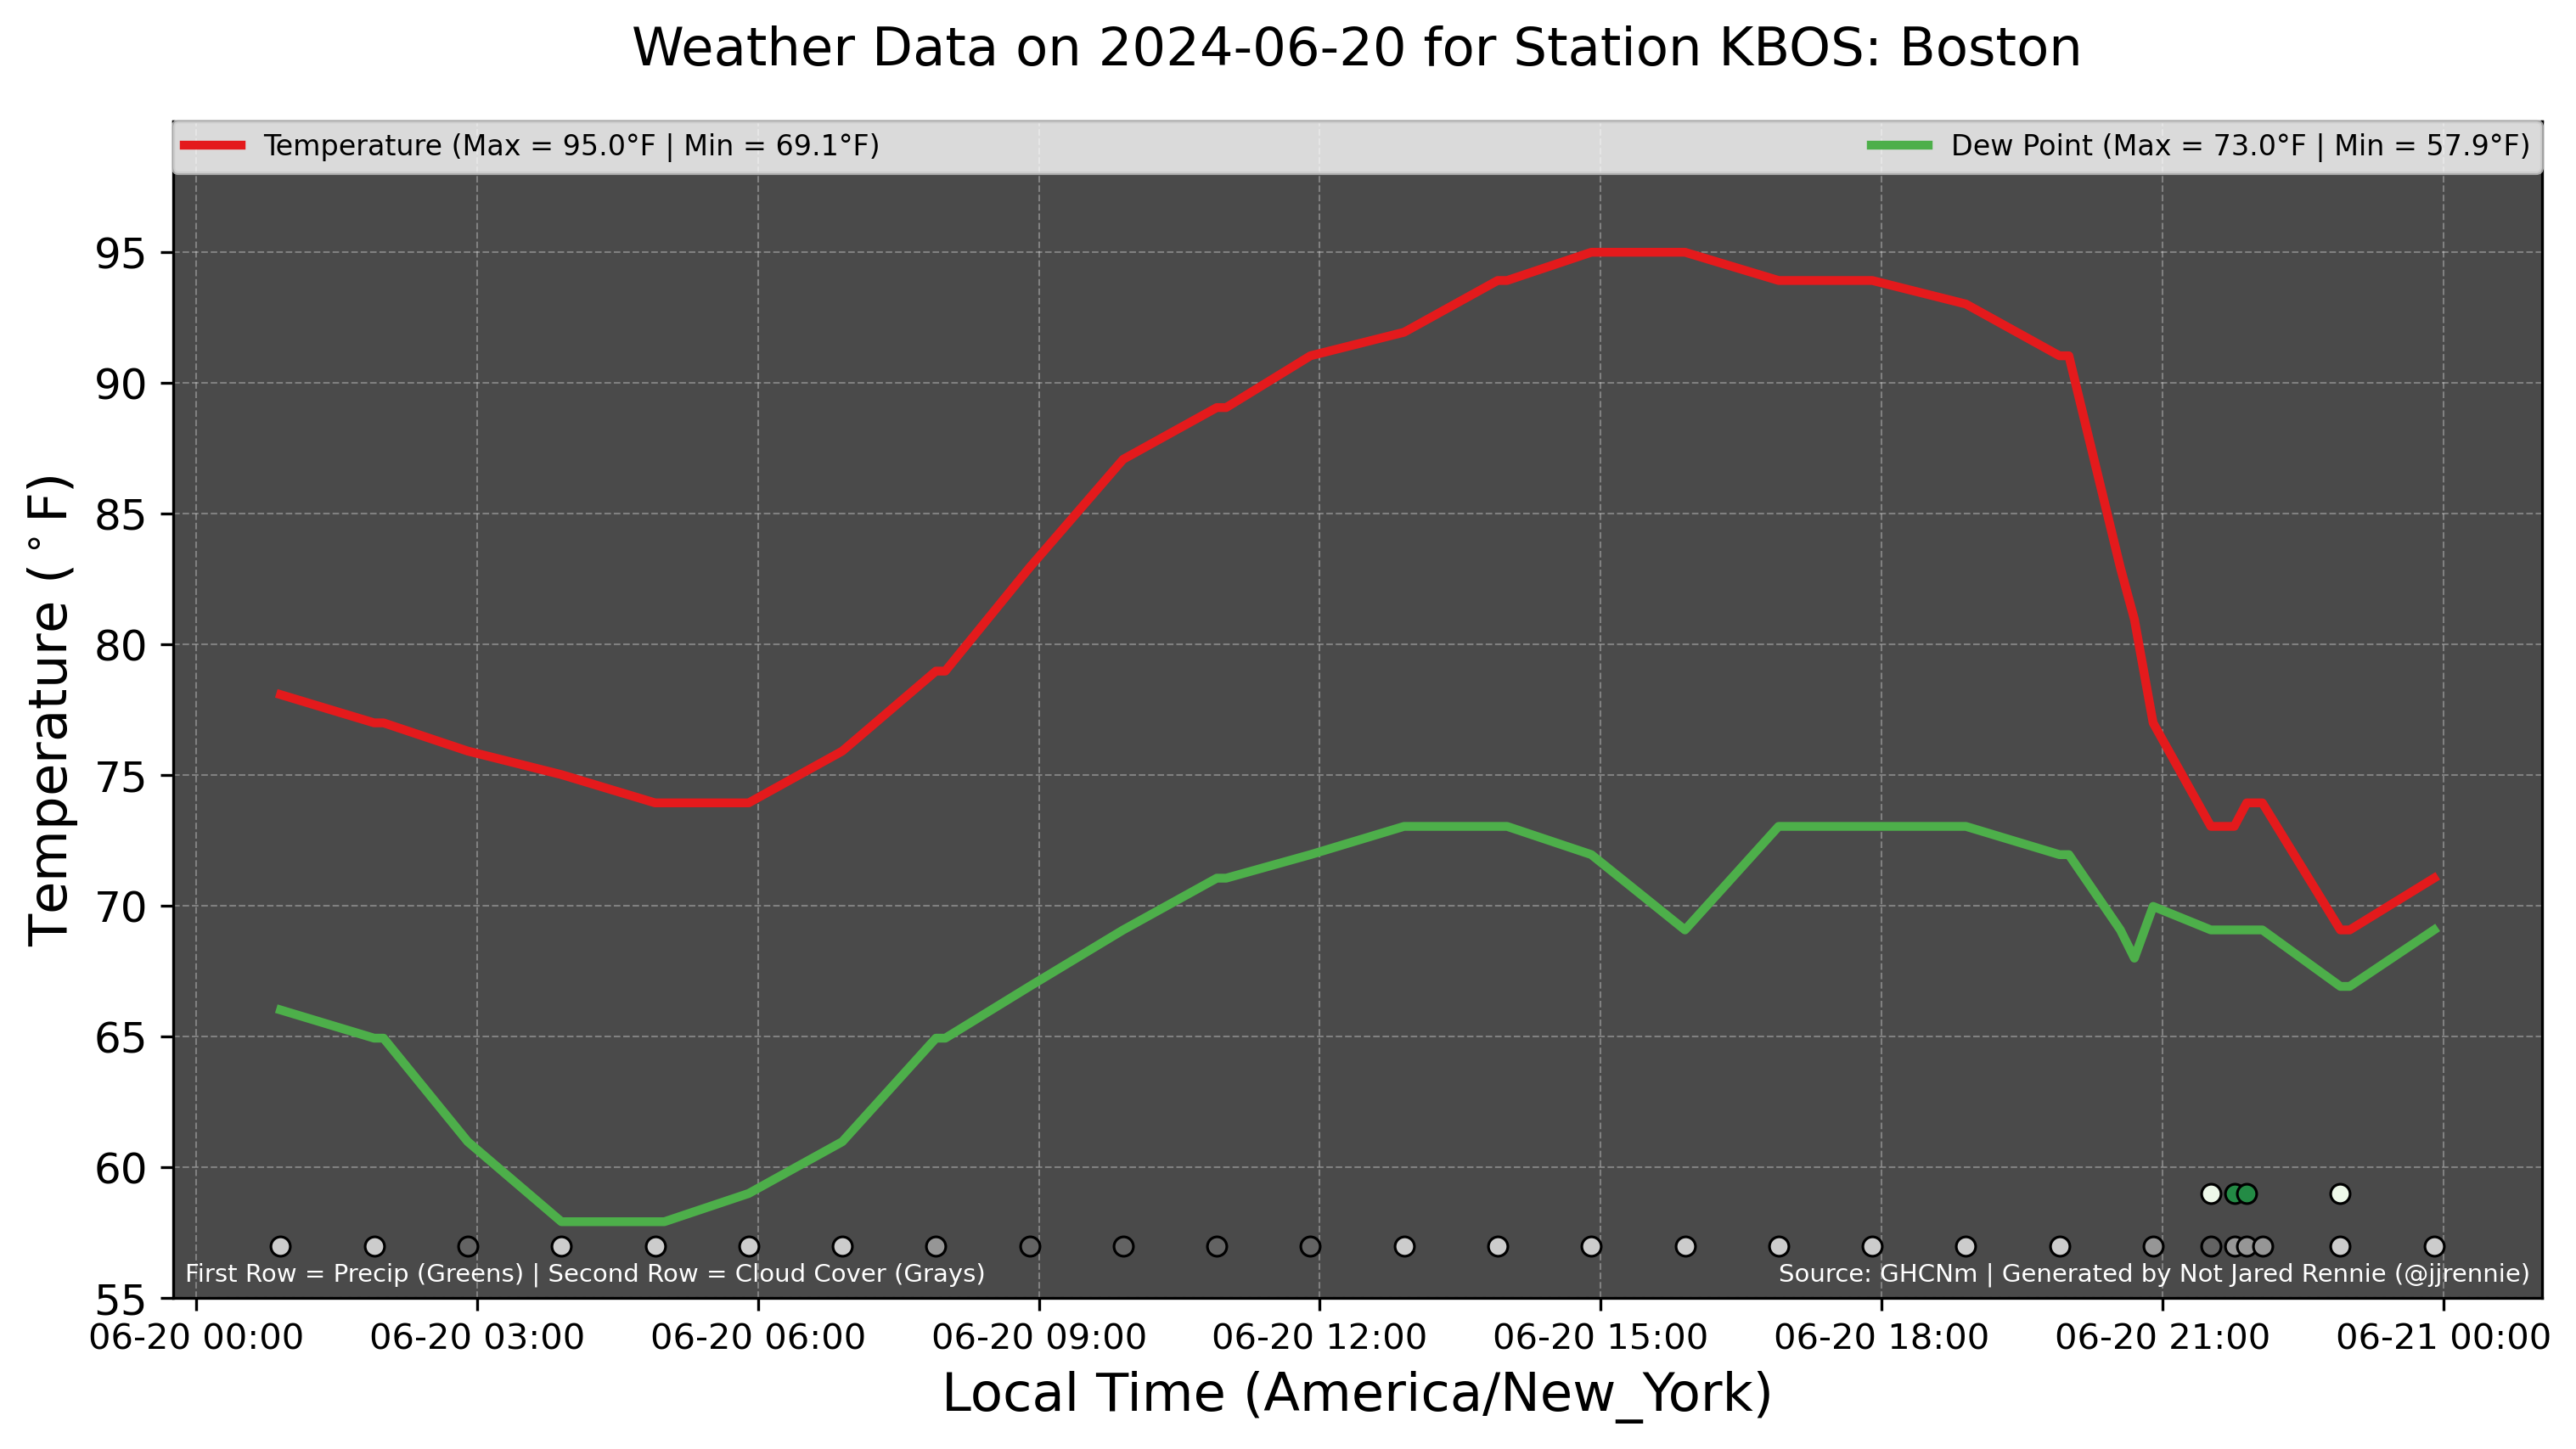

In [10]:
############################################################
# PLOT
print("PLOTTING")
dpi=150

fig, axf = plt.subplots(figsize=(12, 6), edgecolor='white', facecolor='white', dpi=300)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
axf.set_facecolor('#4a4a4a')

# Plot Data
plt.plot(filtered_df['DATE_LOCAL'], filtered_df['temperature'], linewidth=2.5, color='#e41a1c', label="Temperature (Max = "+temp_max+" | Min = "+temp_min+")")
plt.plot(filtered_df['DATE_LOCAL'], filtered_df['dew_point_temperature'], linewidth=2.5, color='#4daf4a', label="Dew Point (Max = "+dewp_max+" | Min = "+dewp_min+")")

# Plot Y Limits
ymin=min(int(5 * round(float((min(filtered_df['dew_point_temperature']) - 5))/5)),9999)
ymax=max(int(5 * round(float((max(filtered_df['temperature']) + 5))/5)),-9999)
plt.ylim(ymin, ymax)

# Plot Precip Info
for index, row in filtered_df_rain.iterrows():
  plt.scatter(row['DATE_LOCAL'],ymin+4,zorder=10, s=30, color=row['precip_color'], alpha=1, edgecolor='black', linewidth=0.75)

# Plot Cloud Info
for index, row in filtered_df_cloud.iterrows():
  plt.scatter(row['DATE_LOCAL'],ymin+2,zorder=10, s=30, color=row['color'], alpha=1, edgecolor='black', linewidth=0.75)

# Plot Legend
plt.legend(loc=9, ncol=2, mode="expand", borderaxespad=0., fontsize=8)

# Plot Y-Axis Label
plt.yticks(range(ymin, ymax, 5), [r'{}'.format(x) for x in range(ymin, ymax, 5)], fontsize=12, color='black')
plt.ylabel(r'Temperature ($^\circ$F)', fontsize=15, color='black')

# Plot X-Axis Label
plt.xlabel(r'Local Time ('+zone_result+')', fontsize=15, color='black')
plt.xticks(color='black')
axf.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M', tz=filtered_df['DATE_LOCAL'].dt.tz))

# Plot Title/Subtitle
plt.title('Weather Data on '+str(inDate)+' for Station '+inStn+': '+str(stnName), fontsize=15, color='black',y=1.03)
plt.annotate('Source: GHCNh | Generated by '+author,xy=(0.995, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom', color='white')
plt.annotate('First Row = Precip (Greens) | Second Row = Cloud Cover (Grays)',xy=(0.005, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='left', verticalalignment='bottom',color='white')

# Save Figure
outfile = './'+inStn+'_'+str(inDate.replace('-',''))+'.png'
plt.savefig(outfile, dpi=dpi,bbox_inches='tight')
plt.show()
plt.clf()
plt.close()

### BONUS: Dewpoint For a Year, with the "Jared is Miserable Index"
Since we ingested a year's worth of data let's aggregate data by day and plot a year's worth of days. Here we will be getting dewpoint data, making daily summaries, then plotting the year's worth. We are also comparing the dewpoint to two really important, self peer reviewed research variables
* Jared is Miserable (Td >= 55F)
* Leave Jared Alone (Td >= 70F)

In [11]:
daily_td = subsetPandas.groupby(pd.to_datetime(subsetPandas['DATE_LOCAL']).dt.date)['dew_point_temperature'].agg(['max', 'min']).reset_index()
daily_td.columns = ['DATE_LOCAL', 'TDMAX', 'TDMIN']

daily_td['TDMAX']=(daily_td['TDMAX'] * 1.8) + 32.
daily_td['TDMIN']=(daily_td['TDMIN'] * 1.8) + 32.
daily_td.max()
daily_td['DATE_LOCAL'] = pd.to_datetime(daily_td['DATE_LOCAL'])
daily_td

,DATE_LOCAL,TDMAX,TDMIN
0,2023-12-31,23.00,21.92
1,2024-01-01,26.96,17.96
2,2024-01-02,24.08,17.06
3,2024-01-03,30.92,24.08
4,2024-01-04,33.08,1.94
...,...,...,...
362,2024-12-27,24.08,17.06
363,2024-12-28,44.96,24.98
364,2024-12-29,48.02,39.02
365,2024-12-30,53.96,33.98


Now let's plot.

PLOTTING


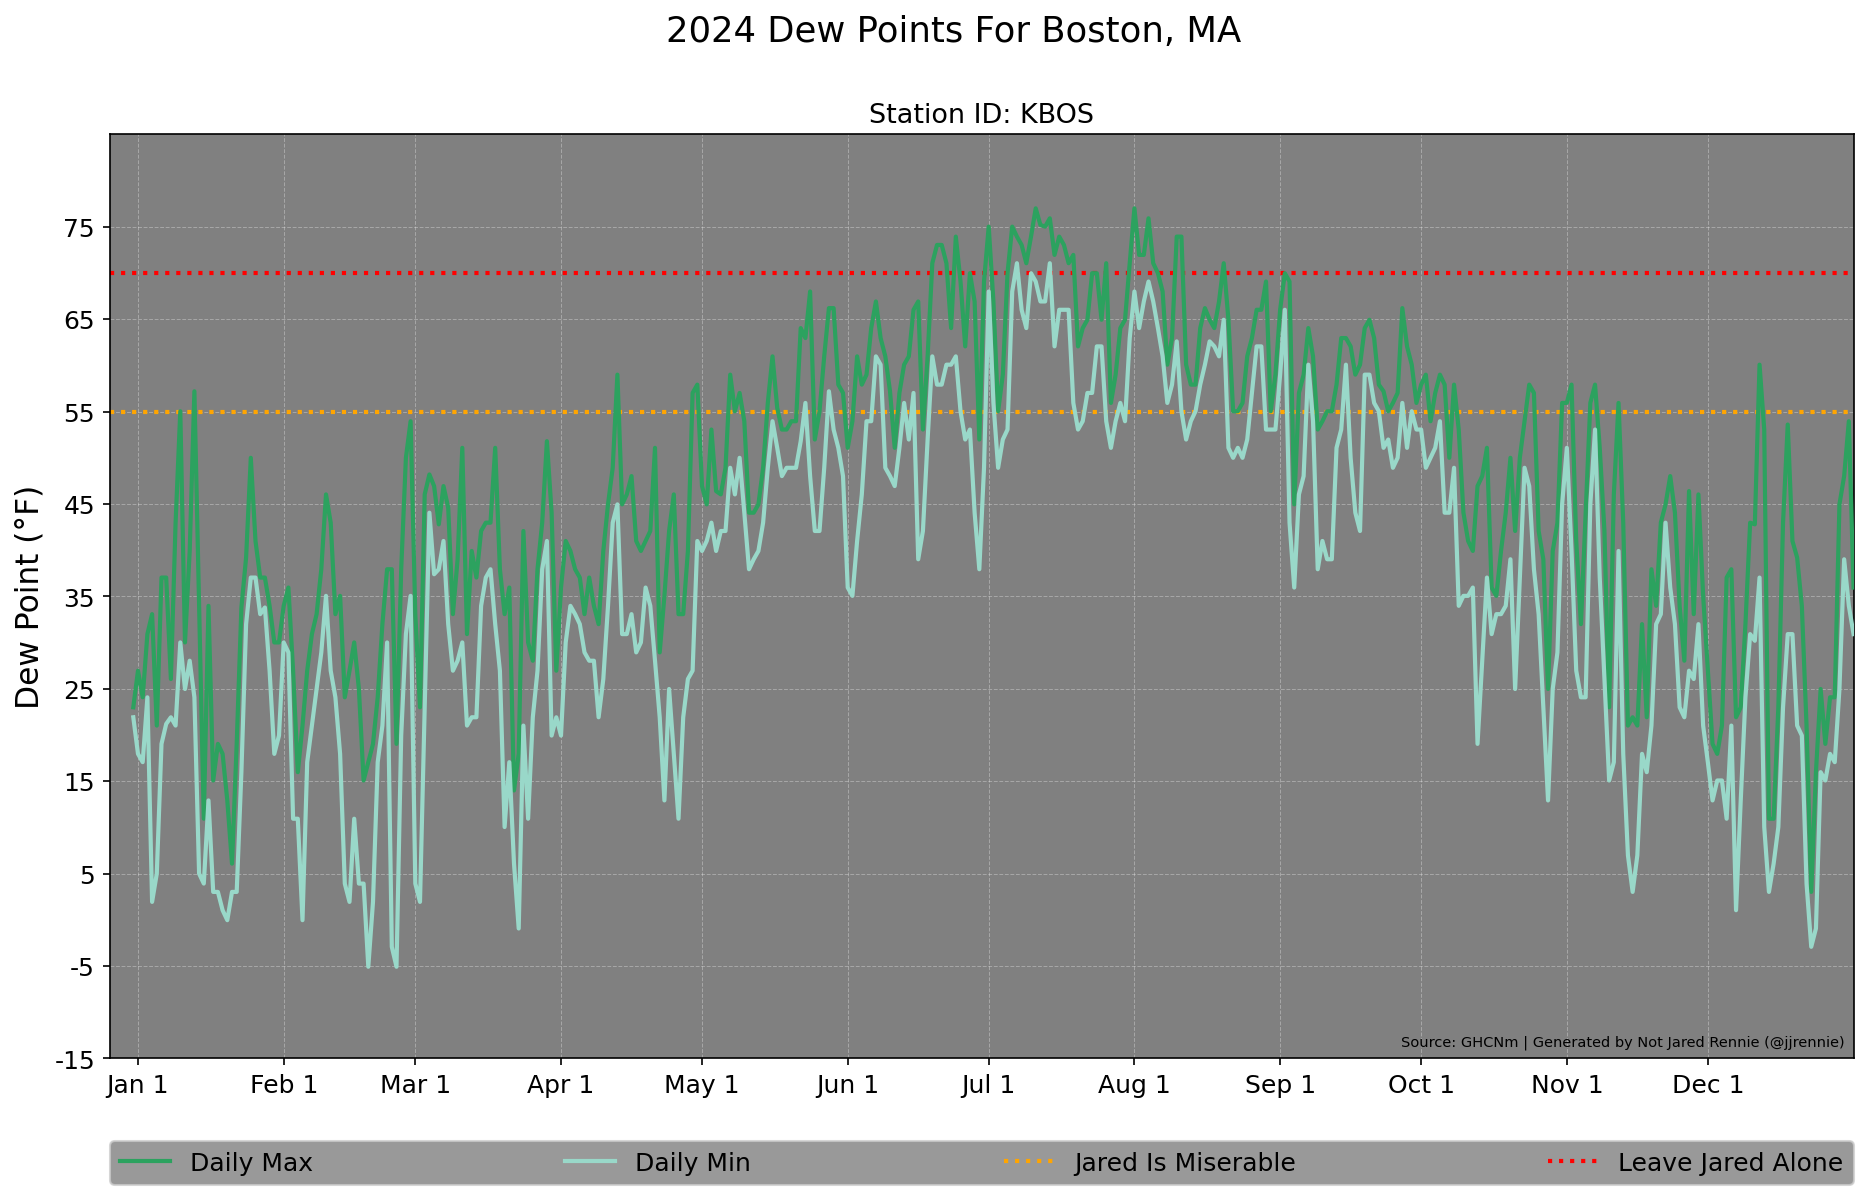

In [12]:
#################################################
# PLOT
print("PLOTTING")

# Set up the plot
fig, axf = plt.subplots(figsize=(15, 8), edgecolor='white', facecolor='white', dpi=dpi)

# Add grid lines
plt.grid(color='white', linestyle='--', linewidth=0.5, alpha=0.3)
axf.set_facecolor('#808080')

# Plot Raw TMAX/TMIN
plt.plot(np.arange(0,len(daily_td['TDMAX'])), daily_td['TDMAX'], linewidth=2, color='#2ca25f', label="Daily Max",zorder=100)
plt.plot(np.arange(0,len(daily_td['TDMIN'])), daily_td['TDMIN'], linewidth=2, color='#99d8c9', label="Daily Min",zorder=100)

# JIM
plt.axhline(y=55., color='orange', linewidth=2.0, linestyle=':', label="Jared Is Miserable")

# LJA
plt.axhline(y=70., color='red', linewidth=2.0, linestyle=':', label="Leave Jared Alone")

# Plot Legend
plt.legend(bbox_to_anchor=(0., -.137, 1., -1.02), loc=3, ncol=6, mode="expand", borderaxespad=0., fontsize=12, facecolor='#808080')

# Set X/Y limits
ymin=-15
ymax=85
plt.ylim(ymin, ymax)
plt.xlim(-5, 366) 
#plt.xlim(daily_td['DATE'].min(), daily_td['DATE'].max())

# Plot X-Axis Labels/Ticks
month_pos=[1,32,60,91,121,152,182,213,244,274,305,335]
month_names=["Jan 1","Feb 1","Mar 1","Apr 1","May 1","Jun 1","Jul 1","Aug 1","Sep 1","Oct 1","Nov 1","Dec 1"]
plt.xticks(month_pos, month_names, fontsize=12, color='black')

# Plot Y-Axis Labels/Ticks (Left Side, degF)
plt.yticks(range(ymin, ymax, 10), [r'{}'.format(x) for x in range(ymin, ymax, 10)], fontsize=12, color='black')
plt.ylabel(r'Dew Point (°F)', fontsize=15, color='black')

# Plot Title/Subtitle/Annotations
plt.suptitle(str(inYear)+' Dew Points For '+stnName+', '+stnState, fontsize=17,color='black')
plt.title('Station ID: '+inStn, fontsize=13,color='black')
plt.annotate('Source: GHCNh | Generated by '+author,xy=(0.995, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom')

# Save Figure
outfile = './'+inStn+'_dewp_'+str(inYear)+'.png'
plt.savefig(outfile, dpi=dpi,bbox_inches='tight')
plt.show()
plt.clf()
plt.close()

Isn't it Beautiful?

**Congrats on completing this notebook! Now go forth and make better data/plots!**